In [1]:
cd ../..

D:\Users\mrefoyo\Proyectos\Sub-SpaCE_plus


In [2]:
import os
import pickle
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf

from experiments.evaluation.evaluation_utils import load_dataset_for_eval, calculate_metrics_for_dataset, calculate_method_valids

print(tf.__version__)

2.13.0


In [7]:
# datasets = ['CBF', 'chinatown', 'coffee', 'gunpoint', 'ECG200']
DATASETS = ["BasicMotions", "NATOPS", "UWaveGestureLibrary"]
model_to_explain = "cls_basic_train"
ae_name = "ae_basic_train"
methods = {
    # Basic experimentos
    # "43b17a2e4f21097540adf8600402c5bd32fa60d6": "subspace_gknn_gch",
    # "37a3f06c077321b95960769282152427a7ee48ae": "subspace_gknn_ich", 
    # "86df14d56b66fecfb65d5805107dfe10961ecae9": "subspace_iknn_gch",     
    # "4f40e39bfe0d3da692b5571d87f7ec915c42eba2": "subspace_iknn_ich", 
    
    # Basic experiments only gknn but with lower gamma (0.125)
    # "4d1faa458bab2b8c6ee14d59b824557fcc80d8e3": "subspace_gknn_gch_gamma0125", 
    # "93c0b5f0630a5dbf5d0377a4f3ff03b6868cbda1": "subspace_iknn_gch_gamma0125", 
    
    # Basic experiments New IoS 
    # "e54dcb25b02132166a719885cad2695540450ee6": "subspace_gknn_gch_ios",
    # "9cdb2fb25d7c664d60da7aa23b4c2c0f9ec9548c": "subspace_gknn_ich_ios",
    # "8c29354f168b9852a05523a7c26ab0f4acb30e9b": "subspace_iknn_gch_ios",
    # "b93fe63854fe36f62900cbcae1c00ad499d41f74": "subspace_iknn_ich_ios",
    
    # Sub-SpaCE v2 con NUN sinteticos
    # "0f31693cb3d17afd3d67191e82e2bca887075ee6": "subspace_gknn_gch_moremut",
    # "988e9ee7e36478e6b02628f6fd15e8f6fdabce63": "subspace_iknn_gch_moremut",
    # "a246def090b506ff8ba41e861e0464493233b9d1": "subspace_gknn_ich_moremut",
    # "de59140e133b8214d6fd39630d49420f41f2f395": "subspace_iknn_ich_moremut",
    # "e4a8da55a30853287350d3540873bcb91cb50b70": "subspace_gknn_cch_moremut",
    # "af3bb75a4e9d84bc4cb545b21941e6750ce17b45": "subspace_iknn_cch_moremut",
    
    # Sub-SpaCE v2 mutation study
    # "a39f776a35cfd7c4530ed4c8f104fcef9b650512": "subspace_gknn_ich_mut01",
    # "99b876d673ecb07aa65860859a2f6467617b8c86": "subspace_gknn_gch_mut01",
    # "7469da9fdf840b4b4c2b38bc4bc9111016b32de5": "subspace_gknn_cch_mut01",
    # "db736bc9c4068ecbfbc96a90e98dc0eb3efbaa92": "subspace_gknn_ich_mut02",
    # "cbbcedcb6d9fd15f864bcc72209e990664f578cc": "subspace_gknn_gch_mut02",
    # "3a2f5d028e5e5ee1637634010ddab48db711879f": "subspace_gknn_cch_mut02",
    # "e702bb244e58da0e7ebbc277bb04c45fb09118aa": "subspace_gknn_ich_mut04",
    # "5643e1c660ae69f41f58f9b71109809ac41d806a": "subspace_gknn_gch_mut04",
    # "d3103c82728b7e2d32be72d2c3029c225869b952": "subspace_gknn_cch_mut04",
    # "6a1225fc4657ca27a9d23ed21050b2fb890175c3": "subspace_gknn_ich_mut05",
    # "41f42efc9de796a8dafc08265dc029d606e452cf": "subspace_gknn_gch_mut05",
    # "2a7b2e8d4df37d7d7ece4e9b45999a3679252362": "subspace_gknn_cch_mut05",
    # "14f1a162dc03f18a16cb1044efd076f3a4fb61a2": "subspace_gknn_ich_mut07",
    # "e76bb3c93b88f711dd5d25a3ac5704c3bf98b4cf": "subspace_gknn_gch_mut07",
    # "e58d4a60e2c54feed0add715c4c3b28afbb37969": "subspace_gknn_cch_mut07",
    # "6d734428c0fea87d3327bea1408b47c483d33e9e": "subspace_gknn_ich_mut09",
    # "e347534c7eb328d5ddafe940f724a02f9a14ec80": "subspace_gknn_gch_mut09",
    # "b945f3452ca7deb539f84c45d6c6202e75563c55": "subspace_gknn_cch_mut09",
    
    # Comparison between FI initializations 
    "d0150639d9caf9cbaa8503c4ad0e6b2ad0f146f5": "subspace_gknn_cch_finone",
    "abd6be72d2e5c0967af2134fe463ff2ad9250524": "subspace_gknn_cch_figradcam",
    "4d454643cf2a5a5fd244b515e49025a40a3865a3": "subspace_gknn_cch_fiIG",
    "94b9fe1099b1177bd2438f8a822ba50796620e17": "subspace_gknn_cch_fiSG",
}

# Get results

In [8]:
from sklearn.preprocessing import MinMaxScaler

def create_fitnes_curve_df(fitness_evolutions, method_name, scale=True):
    if scale:
        scaler = MinMaxScaler()
        scaled_fitness_evolutions = scaler.fit_transform(np.array(fitness_evolutions).T).T
        fitness_df = pd.DataFrame(scaled_fitness_evolutions)
    else:
        fitness_df = pd.DataFrame(np.array(fitness_evolutions))
    # Filter those rows where the last value is 0 (the CF is not valid)
    fitness_df = fitness_df[fitness_df[99]!=0]
    fitness_df = pd.melt(fitness_df.reset_index(), id_vars=['index'], value_vars=fitness_df.columns,
                         var_name='iteration', value_name='fitness')
    fitness_df["method"] = method_name
    return fitness_df

def create_init_fitness_values_df(init_fitness_values, method_name):
    init_fitness_df = pd.DataFrame()
    init_fitness_df['Best Initial Fitness'] = init_fitness_values
    init_fitness_df['Method'] = method_name
    return init_fitness_df

In [13]:
all_fitness_curves_df = pd.DataFrame()
init_fitness_values_df = pd.DataFrame()
for dataset in DATASETS:
    print(f'Calculating fitness curves for {dataset}')
    
    # Load all solutions for the dataset and calculate metrics
    dataset_init_fitness_df = pd.DataFrame()
    dataset_fitness_df = pd.DataFrame()
    cf_solution_dirs = [fname for fname in os.listdir(f'./experiments/results/{dataset}/{model_to_explain}') if os.path.isdir(f'./experiments/results/{dataset}/{model_to_explain}/{fname}')]
    desired_cf_solution_dirs = [cf_sol_dir for cf_sol_dir in cf_solution_dirs if cf_sol_dir in methods.keys()]
    valid_cf_solution_dirs = [cf_sol_dir for cf_sol_dir in desired_cf_solution_dirs if os.path.isfile(f'./experiments/results/{dataset}/{model_to_explain}/{cf_sol_dir}/counterfactuals.pickle')]

    for i, method_dir_name in enumerate(valid_cf_solution_dirs):
        method_name = methods[method_dir_name]
        print(method_name)
        with open(f'./experiments/results/{dataset}/{model_to_explain}/{method_dir_name}/counterfactuals.pickle', 'rb') as f:
            method_cfs = pickle.load(f)
            counterfactuals = [solution['cf'] for solution in method_cfs]
            original_fitness_evolutions = [solution['fitness_evolution'] for solution in method_cfs]
        # Load params
        with open(f'./experiments/results/{dataset}/{model_to_explain}/{method_dir_name}/params.json', 'r') as json_file:
            method_params = json.load(json_file)
            method_test_indexes = method_params["X_test_indexes"]
            
        # GET FITNESS VALUES
        initial_fitness_list = [fitness_evolution[0] for fitness_evolution in original_fitness_evolutions]

        # Create Fitness evolutions with valid info for getting convergence
        # Keep only the last 100 iterations as this is the max number of iteration used in the experiments.
        fitness_evolutions = [fitness_evolution[-100:] for fitness_evolution in original_fitness_evolutions]
        # Fill with the last existing value at the end in case of early convergence (all mask with the same value)
        fitness_evolutions = [fitness_evolution + [fitness_evolution[-1]]*(100-len(fitness_evolution))
                              if len(fitness_evolution) != 100 else fitness_evolution
                              for fitness_evolution in fitness_evolutions]
            
        # GET VALID COUNTERFACTUALS
        data_tuple, original_classes, model, outlier_calculator, possible_nuns, desired_classes = load_dataset_for_eval(dataset, model_to_explain, ae_name)
        
        # Get the metrics for all methods
        X_train, y_train, X_test, y_test = data_tuple
        valids = calculate_method_valids(model, X_test[method_test_indexes], counterfactuals,
                                         original_classes[method_test_indexes])

        # FILTER NON VALID COUNTERFACTUALS
        valid_fitness_evolutions = [fitness_evolution for fitness_evolution, valid in zip(fitness_evolutions, valids) if valid==True]

        # GET FITNESS CURVES
        fitness_evolutions_df = create_fitnes_curve_df(valid_fitness_evolutions, method_name, scale=False)
        dataset_fitness_df = pd.concat([dataset_fitness_df, fitness_evolutions_df])
        # Get data for initial fitness values
        init_fitness_df = create_init_fitness_values_df(initial_fitness_list, method_name)
        dataset_init_fitness_df = pd.concat([dataset_init_fitness_df, init_fitness_df])

    dataset_fitness_df['dataset'] = dataset
    dataset_init_fitness_df['dataset'] = dataset
    all_fitness_curves_df = pd.concat([all_fitness_curves_df, dataset_fitness_df])
    init_fitness_values_df = pd.concat([init_fitness_values_df, dataset_init_fitness_df])

Calculating fitness curves for BasicMotions
subspace_gknn_cch_fiIG


100%|██████████| 40/40 [00:01<00:00, 20.69it/s]


subspace_gknn_cch_fiSG


100%|██████████| 40/40 [00:02<00:00, 19.33it/s]


subspace_gknn_cch_figradcam


100%|██████████| 40/40 [00:01<00:00, 21.06it/s]


subspace_gknn_cch_finone


100%|██████████| 40/40 [00:01<00:00, 20.94it/s]


Calculating fitness curves for NATOPS
subspace_gknn_cch_fiIG


100%|██████████| 100/100 [00:04<00:00, 20.86it/s]


subspace_gknn_cch_fiSG


100%|██████████| 100/100 [00:04<00:00, 21.00it/s]


subspace_gknn_cch_figradcam


100%|██████████| 100/100 [00:04<00:00, 21.14it/s]


subspace_gknn_cch_finone


100%|██████████| 100/100 [00:04<00:00, 21.07it/s]


Calculating fitness curves for UWaveGestureLibrary
subspace_gknn_cch_fiIG


100%|██████████| 100/100 [00:04<00:00, 20.93it/s]


subspace_gknn_cch_fiSG


100%|██████████| 100/100 [00:04<00:00, 20.77it/s]


subspace_gknn_cch_figradcam


100%|██████████| 100/100 [00:04<00:00, 20.73it/s]


subspace_gknn_cch_finone


100%|██████████| 100/100 [00:04<00:00, 20.78it/s]


In [14]:
all_fitness_curves_df

,index,iteration,fitness,method,dataset
0,0,0,-0.152801,subspace_gknn_cch_fiIG,BasicMotions
1,1,0,-0.161934,subspace_gknn_cch_fiIG,BasicMotions
2,2,0,-0.135597,subspace_gknn_cch_fiIG,BasicMotions
3,3,0,-0.251682,subspace_gknn_cch_fiIG,BasicMotions
4,4,0,-0.146899,subspace_gknn_cch_fiIG,BasicMotions
...,...,...,...,...,...
9995,95,99,0.004121,subspace_gknn_cch_finone,UWaveGestureLibrary
9996,96,99,-0.089400,subspace_gknn_cch_finone,UWaveGestureLibrary
9997,97,99,0.019145,subspace_gknn_cch_finone,UWaveGestureLibrary
9998,98,99,-0.100494,subspace_gknn_cch_finone,UWaveGestureLibrary


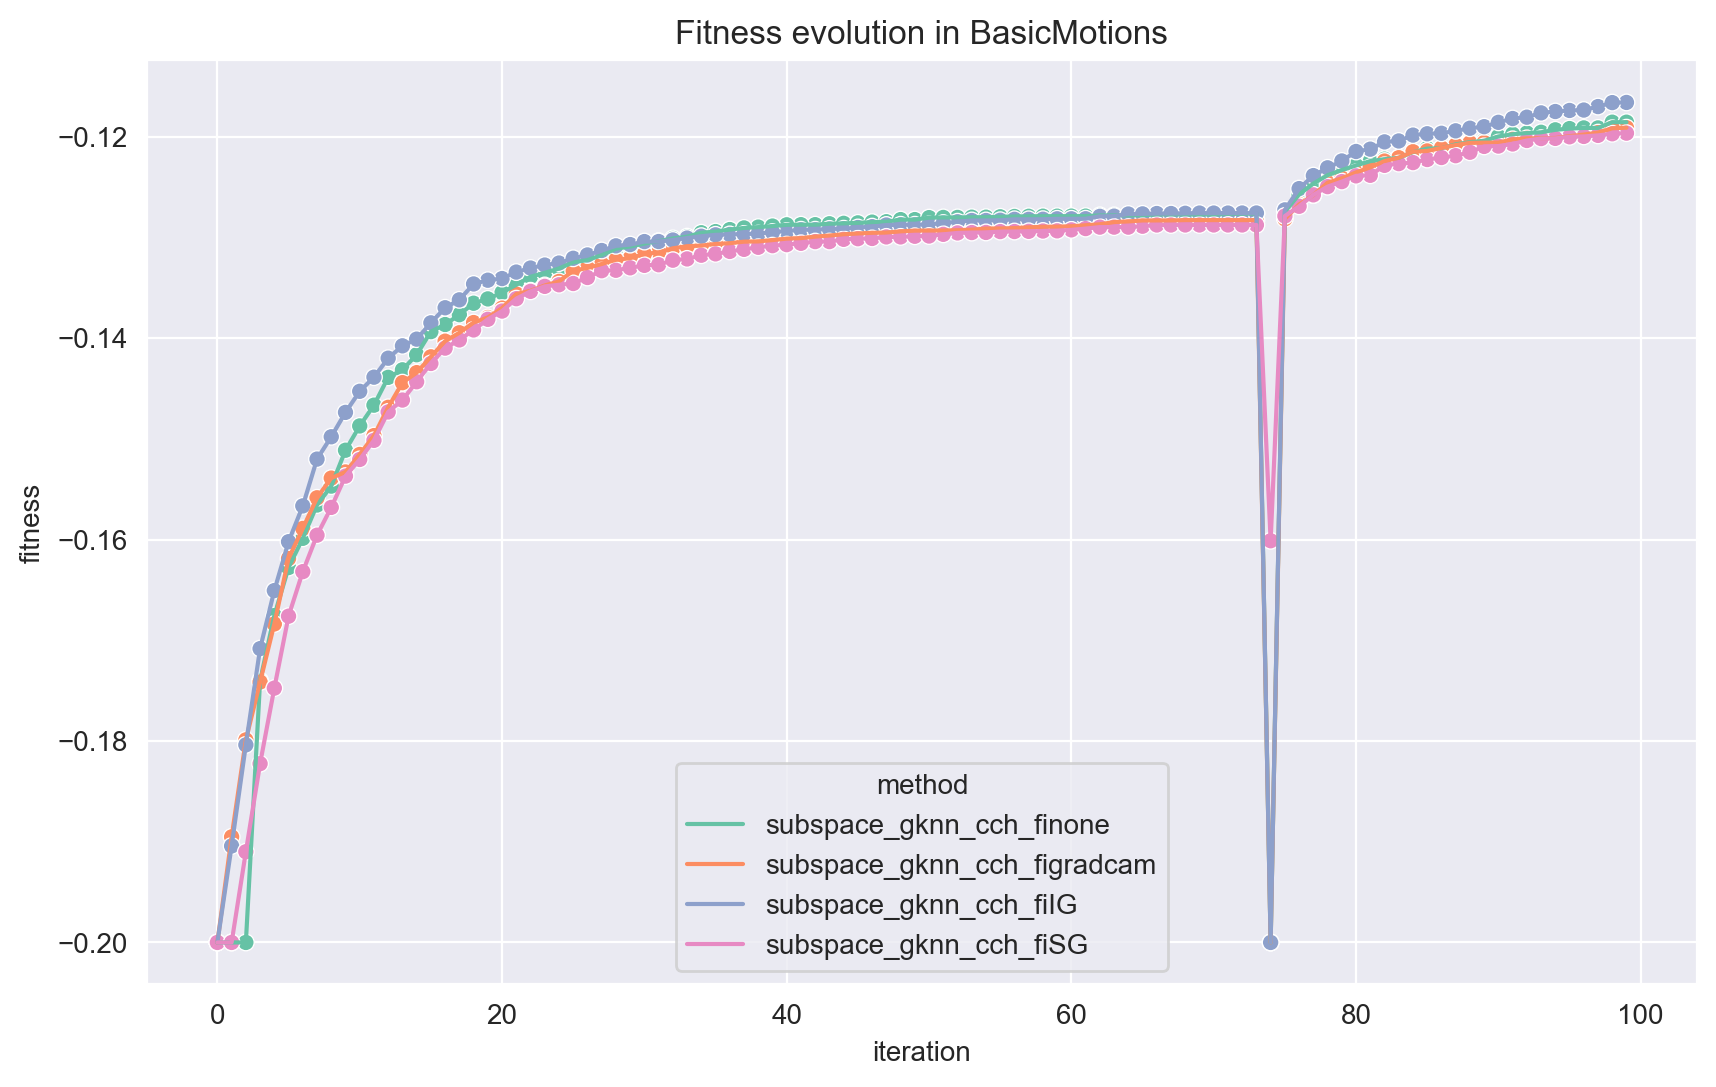

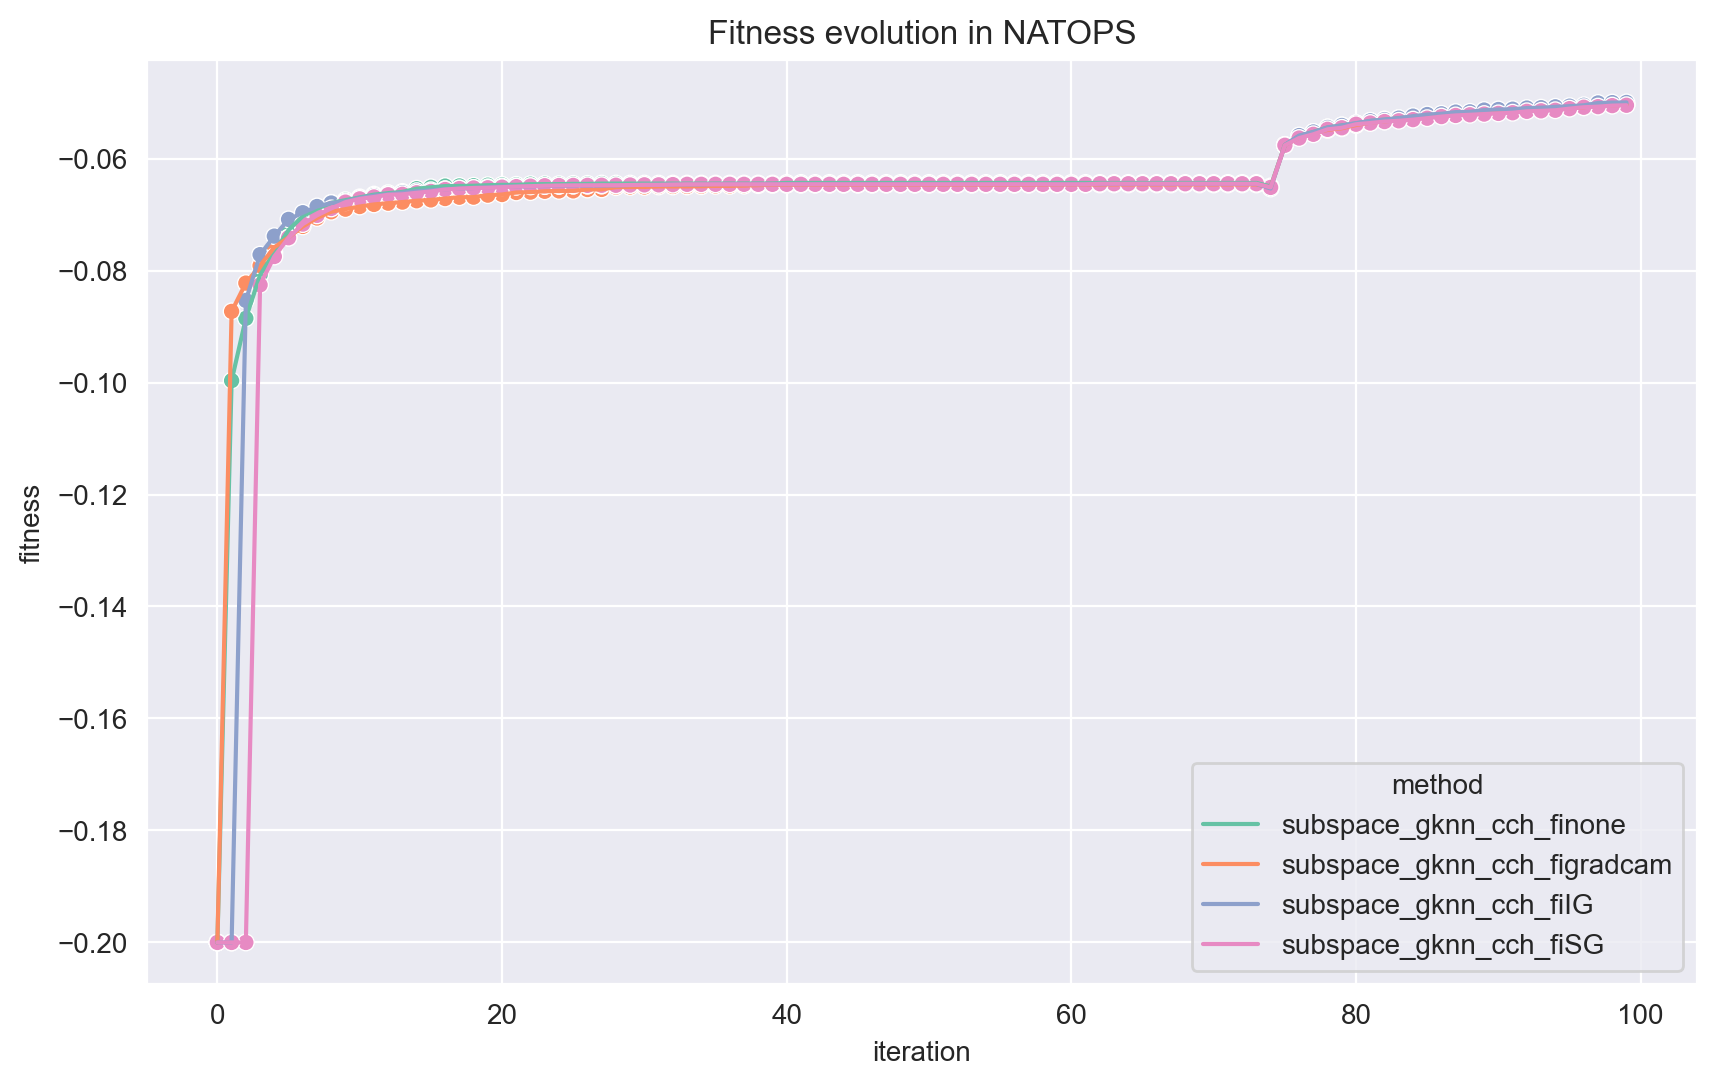

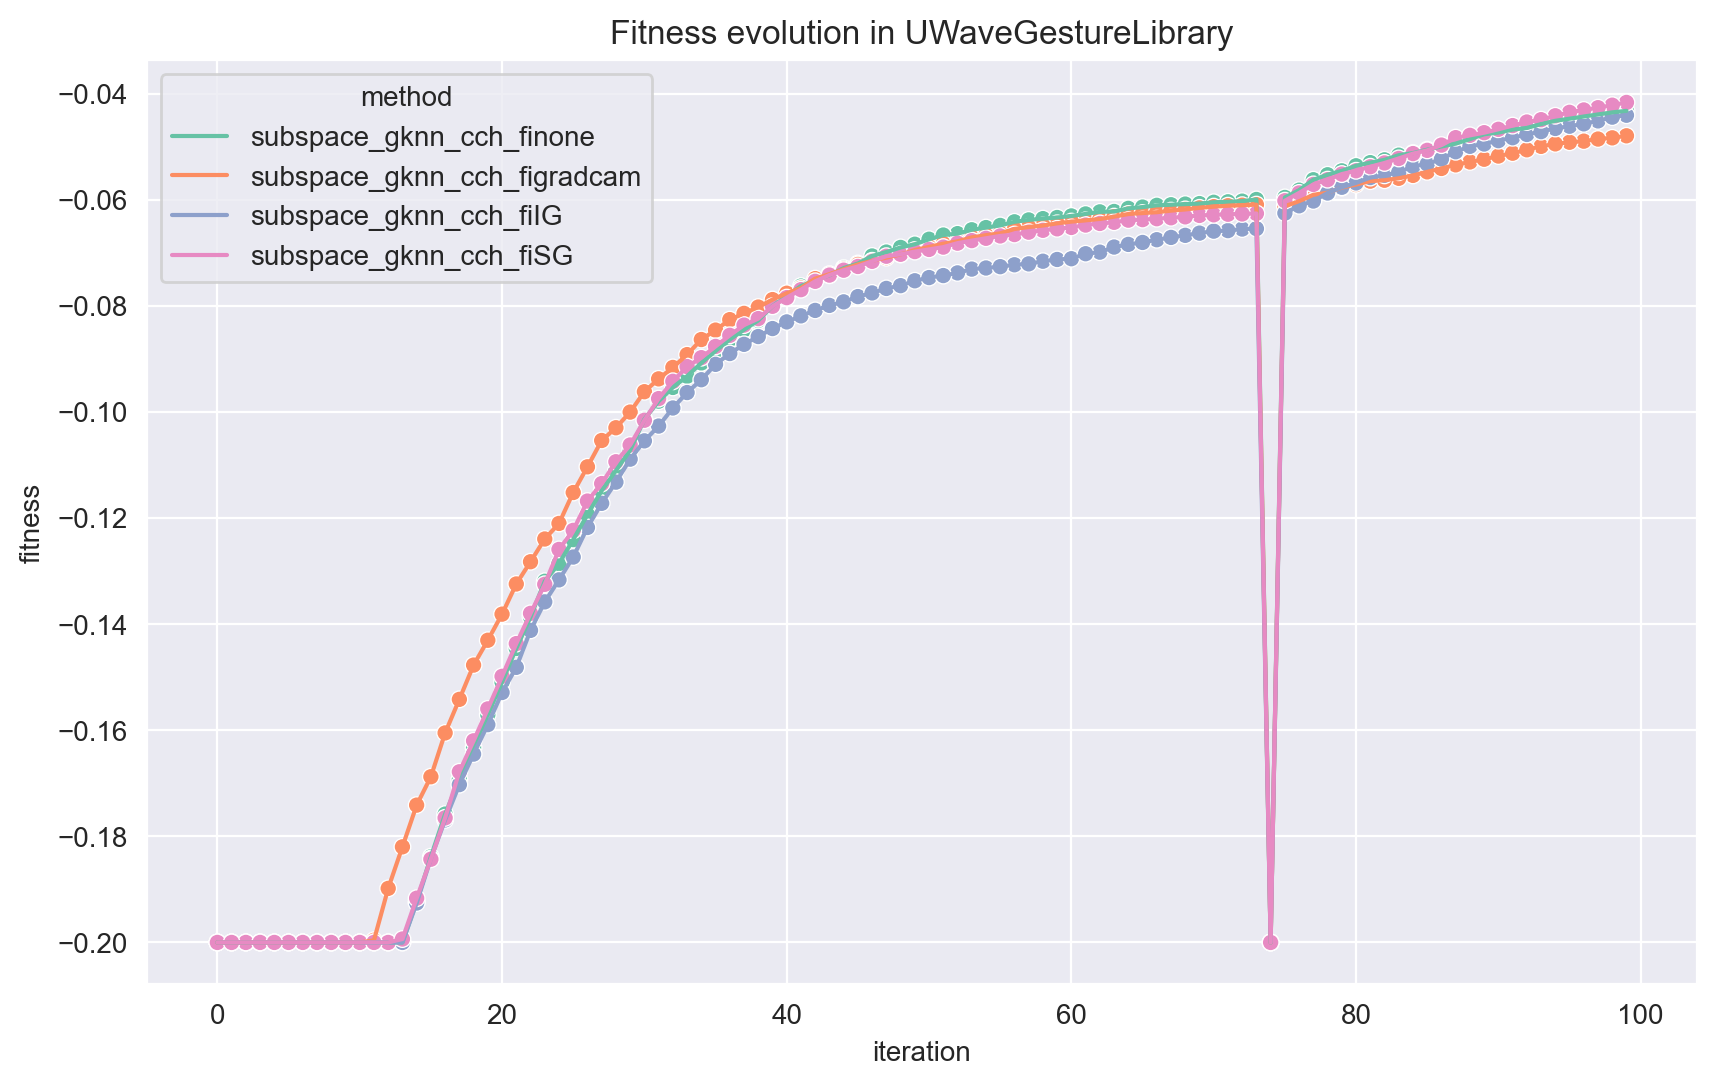

In [15]:
import seaborn as sns

aux_df = all_fitness_curves_df.copy()
methods_order = dict(zip(list(methods.values()), list(range(len(methods)))))

for dataset in DATASETS:
    dataset_fitness_df = aux_df[aux_df['dataset'] == dataset]
    dataset_fitness_mean_df = dataset_fitness_df.groupby(['iteration', 'method'])['fitness'].mean().reset_index()
    dataset_fitness_mean_df['method_ord'] = dataset_fitness_mean_df['method'].map(methods_order)
    dataset_fitness_mean_df = dataset_fitness_mean_df.sort_values('method_ord', ascending=True)
    # Clip values for visualization
    dataset_fitness_mean_df['fitness'].clip(lower=-0.2, upper=None, inplace=True)

    plt.figure(figsize=(10, 6), dpi=200) 
    sns.lineplot(data=dataset_fitness_mean_df, x="iteration", y="fitness", hue="method", palette="Set2").set_title(f'Fitness evolution in {dataset}')
    sns.scatterplot(data=dataset_fitness_mean_df, x="iteration", y="fitness", hue="method", palette="Set2", legend=False)
    plt.show()